<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/Reflexion_Agent_using_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Required Dependencies

In [1]:
%pip install -qU langchain langchain_openai langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00


#### Setup API key

In [13]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

#### Define classes

In [56]:
from typing import List
from pydantic import BaseModel,Field
#
class Reflection(BaseModel):
  print("----------REFLECTION------------------")
  missing: str = Field(description="Critique of what is missing.")
  superflous:str = Field(description="Critique of what is superflous")

#
class AnswerQuestion(BaseModel):
  print("----------ANSWER QUESTION------------------")
  answer:str = Field(description="`250 word detailed answer to the question.")
  reflection:Reflection = Field(description="Your Reflection on the initial answer.")
  search_queries:List[str] = Field(description="1-3 search queries for researching improvements to address the critique of your current answer.")

#
#forcing citations in the model encourages ground responses
class ReviseAnswer(AnswerQuestion):
  print("----------REVISE ANSWER------------------")
  referrences: List[str] = Field(description="Citations motivating your updated answer.")

----------REFLECTION------------------
----------ANSWER QUESTION------------------
----------REVISE ANSWER------------------


#### Instantiate LLM

In [58]:
from langchain_groq import ChatGroq
MODEL = "llama3-groq-70b-8192-tool-use-preview"
llm =ChatGroq(model_name=MODEL,temperature=0.0,max_tokens=3000)

#### Define Relexion Chains

In [59]:
import datetime
from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate,MessagesPlaceholder
from langchain_core.output_parsers import PydanticToolsParser,JsonOutputToolsParser
#
actor_template = ChatPromptTemplate.from_messages([
    ("system","""You are an expert researcher.
    Current Time :{time}

    1. {first_instruction}
    2. Reflect and critique your answer.Be severe to maximize improvement.
    3. Recommend search queries to reserch information and improve your answer."""
    ),
    MessagesPlaceholder(variable_name="messages"),
    ("system","Answer the user's question above using the required format.")
]).partial(time=lambda:datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


In [60]:
first_responder = actor_template.partial(
first_instruction="Provide a detailed ~250 word answer to the question."
) | llm.bind_tools(tools=[AnswerQuestion],tool_choice="AnswerQuestion")


#### Define Validator Tool

In [61]:
validator = PydanticToolsParser(tools=[AnswerQuestion])

#### Reviser tool

In [62]:
revise_instructions = """Revise your previous answer using the new information.
-You should use the previous critique to add important information to your answer.
- You MUST include numerical citations in your revised answer to ensure it can be verified.
- Add a 'Referrences' section to the bottom of your answer (Which does not count towards the word limit). In form of
  - [1] https://example.com
  - [2] https://example.com
- You should use the previous critique to remove superflous information from your answer and make SURE it is no more than 250 words.
"""
revisor = actor_template.partial(
first_instruction=revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer],tool_choice="ReviseAnswer")

#### Define the Tool

In [63]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode
#
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search,max_results=5)
#

In [64]:
def run_queries(search_queries:List[str]):
  """Run the generated queries"""
  return tavily_tool.batch([{"query":query} for query in search_queries])

In [65]:
tool_node = ToolNode(
    [StructuredTool.from_function(run_queries,name=AnswerQuestion.__name__),
     StructuredTool.from_function(run_queries,name=ReviseAnswer.__name__),
    ]
)

## Define Node

In [66]:
from langgraph.graph import START,MessageGraph,StateGraph,END
#
max_iterations=3
builder = MessageGraph()
builder.add_node("draft",first_responder)
builder.add_node("execute_tool",tool_node)
builder.add_node("revise",revisor)
#
builder.add_edge("draft","execute_tool")
builder.add_edge("execute_tool","revise")
#

#### Define Event Loop

In [73]:
from langchain_core.messages import BaseMessage,ToolMessage
from langchain_core.callbacks import CallbackManager
max_iterations =2
def event_loop(state:List[BaseMessage]):
  count_tool_visits = sum(isinstance(item,ToolMessage) for item in state)
  if count_tool_visits >= max_iterations:
    return END
  return "execute_tool"

In [68]:
builder.add_conditional_edges("revise",event_loop)
builder.set_entry_point("draft")
graph = builder.compile()

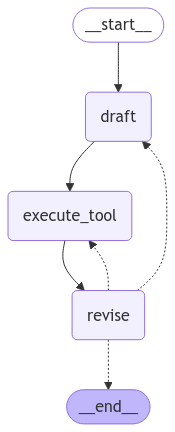

In [25]:
from IPython.display import display,Markdown,Image
display(Image(graph.get_graph().draw_mermaid_png()))
#

In [74]:
res = graph.invoke("Write about PydanticAI agent framework.")

In [75]:
res[-1].tool_calls[0]

{'name': 'ReviseAnswer',
 'args': {'answer': 'The PydanticAI agent framework is a powerful tool for building complex AI applications, offering a structured way to define and manage AI agents, efficient communication, and task distribution. It simplifies the development process and ensures applications are scalable and efficient. The framework supports a variety of AI algorithms and can be easily integrated with existing systems, making it a versatile choice for both new and existing projects. For instance, it can be used to create customer service AI agents that assist human agents by automating repetitive tasks, suggesting responses, and streamlining workflows. Additionally, it can be applied in research and document analysis, such as reading unstructured documents, summarizing content, and mapping company names to tickers for investment analysis. Its applications are revolutionizing the way we build intelligent applications, enabling developers to create sophisticated AI systems that

In [72]:
res[-1].tool_calls[0]['args']['answer']

'Multi-agent frameworks are a type of software that supports the development of multi-agent systems. These frameworks provide a set of tools, libraries, and services that enable the creation of complex systems where multiple agents can interact, collaborate, and adapt to their environment. They are designed to manage the complexity of developing and running multi-agent systems by providing abstractions, APIs, and runtime environments. Key features include agent management, communication protocols, task scheduling, and conflict resolution mechanisms. These frameworks are applied in various domains such as healthcare, transportation, and e-commerce, where distributed problem-solving and decision-making are crucial. They offer benefits like improved system scalability, flexibility, and fault tolerance. Researchers and practitioners use multi-agent frameworks to model and simulate complex scenarios, test algorithms, and validate system designs before deployment. The development of these fr

In [77]:
res[0]

HumanMessage(content='Write about PydanticAI agent framework.', additional_kwargs={}, response_metadata={}, id='ab675083-e0d6-4d1e-b9ce-5893f2511281')

In [78]:
res[1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wc24', 'function': {'arguments': '{"answer": "The PydanticAI agent framework is a powerful tool for building complex AI applications. It provides a structured way to define and manage AI agents, allowing for efficient communication and task distribution. With PydanticAI, developers can create a wide range of AI applications, from simple bots to complex multi-agent systems, all within a well-defined and maintainable framework. This not only simplifies the development process but also ensures that the resulting applications are scalable and efficient. Additionally, the framework supports a variety of AI algorithms and can be easily integrated with existing systems, making it a versatile choice for both new and existing projects.", "reflection": {"missing": "Could include specific use cases or examples of applications built with the framework to make the answer more concrete and practical.", "superflous": "The descriptio

#### Error

* BadRequestError: Error code: 400 - {'error': {'message': 'Please reduce the length of the messages or completion.', 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}



Hypothesis
The error message BadRequestError: Error code: 400 - {'error': {'message': 'Please reduce the length of the messages or completion.', 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}} indicates that the request sent to the Groq API is exceeding the maximum context length allowed by the model you are using (llama3-groq-70b-8192-tool-use-preview).

This is likely happening because:

Accumulation of Messages: The event_loop function allows the graph to iterate multiple times ("execute_tool" -> "revise"), and with each iteration, the message history grows. After a few iterations, the total length of messages and the new prompt might exceed the model's context window.
Long Input Prompt: The initial prompt "Write about Multi-Agentic Frameworks." might already be quite large, especially if previous interactions have added to the message history.
Model Limitations: The llama3-groq-70b-8192-tool-use-preview model has a context window limit. When the total length of the messages and the new prompt exceeds this limit, the API returns a 400 error.
Suggested Changes
To fix this issue, you can try the following:

Reduce the Number of Iterations: Reduce the max_iterations value in your event_loop function to limit the number of times the graph iterates and accumulates messages.

max_iterations = 1  # Reduced from 2 to 1
   def event_loop(state:List[BaseMessage]):
     count_tool_visits = sum(isinstance(item,ToolMessage) for item in state)
     if count_tool_visits >= max_iterations:
       return END
     return "execute_tool"
Use code with caution
Shorten the Input Prompt: Try providing a shorter, more specific initial prompt to reduce the initial context size. For example, instead of "Write about Multi-Agentic Frameworks.", you could try "Explain the key concepts of Multi-Agentic Frameworks."

Memory Management: Implement a memory management strategy to trim the conversation history. You could keep only the most recent or relevant messages, summarize previous exchanges, or use a sliding window to limit the history size. LangChain offers various memory implementations that can be integrated into your chain.

Increase max_tokens in llm instantiation: If possible, increase the max_tokens parameter when instantiating the ChatGroq object. However, be mindful of the model's context window limit.


llm = ChatGroq(model_name=MODEL, temperature=0.0, max_tokens=2000)  # Increased max_tokens
Use code with caution
By implementing these changes, you can reduce the likelihood of exceeding the context window limit and avoid the BadRequestError. Remember to experiment with different approaches to find the best solution for your specific use case.

Sources